## Multipose 
COCO Output Format
Nose – 0, Neck – 1, Right Shoulder – 2, Right Elbow – 3, Right Wrist – 4,
Left Shoulder – 5, Left Elbow – 6, Left Wrist – 7, Right Hip – 8,
Right Knee – 9, Right Ankle – 10, Left Hip – 11, Left Knee – 12,
LAnkle – 13, Right Eye – 14, Left Eye – 15, Right Ear – 16,
Left Ear – 17, Background – 18

#### https://learnopencv.com/multi-person-pose-estimation-in-opencv-using-openpose/
#### https://github.com/spmallick/learnopencv/tree/master/OpenPose-Multi-Person

In [1]:
# Download weights from
#http://posefs1.perception.cs.cmu.edu/OpenPose/models/

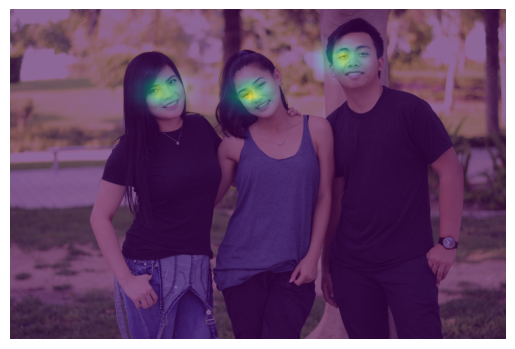

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

proto_file = "Media/M4/Model/pose_deploy_linevec.prototxt"
weights = "Media/M4/Model/pose_iter_440000.caffemodel"
net = cv2.dnn.readNetFromCaffe(proto_file, weights)

image1 = cv2.imread("Media/M4/face6.jpg")

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

inWidth  = image1.shape[1]
inHeight = image1.shape[0]
#print(image1.shape)

netInputSize = (250,250)
inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, netInputSize, (0, 0, 0), swapRB=True, crop=False)

net.setInput(inpBlob)
output = net.forward()

(frameWidth, frameHeight) = netInputSize

i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (inWidth, inHeight))
 
plt.imshow(image1);plt.axis("off");
plt.imshow(probMap, alpha=0.6)

In [3]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint

In [4]:
#device = "gpu" # for cuda.
device = "cpu"

In [5]:
#protoFile = "pose/coco/pose_deploy_linevec.prototxt"
#weightsFile = "pose/coco/pose_iter_440000.caffemodel"
protoFile = "Media/M4/Model/pose_deploy_linevec.prototxt"
weightsFile = "Media/M4/Model/pose_iter_440000.caffemodel"

nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

In [6]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

In [7]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs

In [8]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

## Load Image and create input blob

In [9]:
#image1 = cv2.imread("group.jpg")
image1 = cv2.imread("Media/M4/face6.jpg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

# Forward pass through the Net
net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Using CPU device
Time Taken = 8.513224124908447


In [10]:
## Sample Output

(-0.5, 3007.5, 1999.5, -0.5)

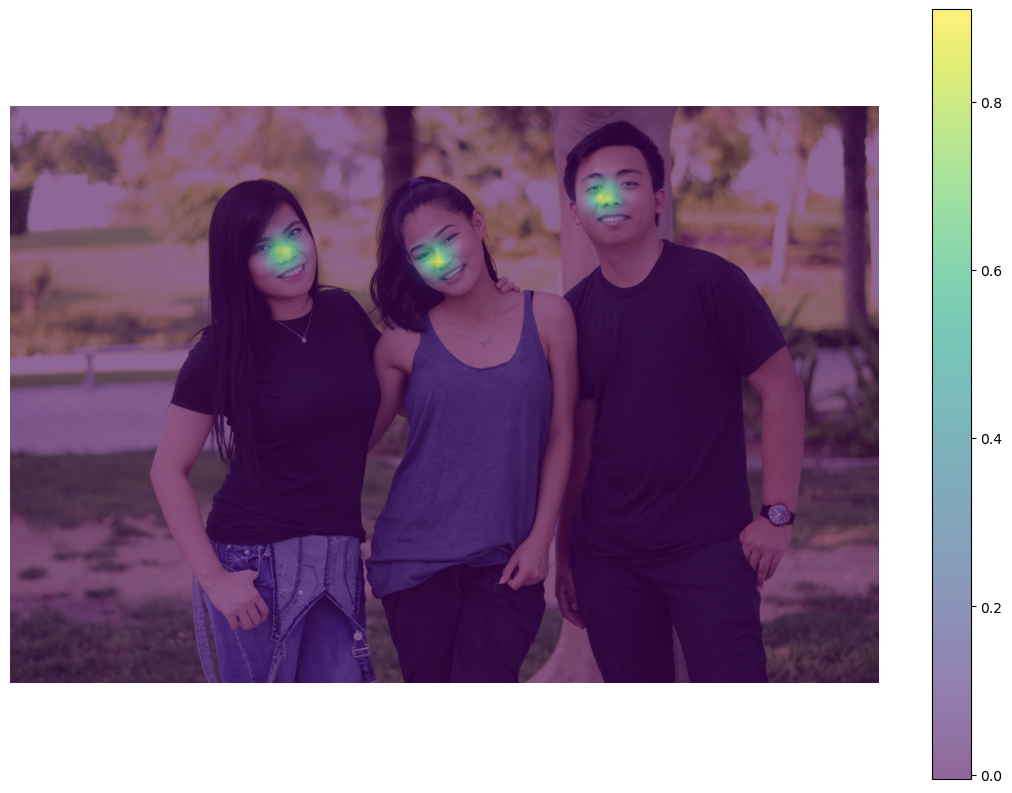

In [11]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

## Detection of keypoints

In [12]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
    #plt.figure()
    #plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

Keypoints - Nose : [(1482, 543, 0.9098527), (965, 500, 0.7808423), (2042, 325, 0.8174124)]
Keypoints - Neck : [(923, 803, 0.7400794), (1610, 761, 0.6973329), (2170, 673, 0.7791527)]
Keypoints - R-Sho : [(708, 848, 0.63009167), (1311, 847, 0.7047616), (1913, 717, 0.61941403)]
Keypoints - R-Elb : [(537, 1281, 0.74235684), (1954, 1108, 0.22949874), (1309, 1022, 0.24635431)]
Keypoints - R-Wr : [(708, 1630, 0.71137035), (1911, 1585, 0.20062469), (1180, 1195, 0.17132469)]
Keypoints - L-Sho : [(1826, 717, 0.7116032), (1138, 716, 0.71191835), (2427, 629, 0.623815)]
Keypoints - L-Elb : [(1910, 1110, 0.64038515), (2642, 978, 0.7258687), (1310, 978, 0.50861245)]
Keypoints - L-Wr : [(1826, 1499, 0.8196634), (2642, 1412, 0.7215421), (1181, 1195, 0.1684402)]
Keypoints - R-Hip : [(2041, 1543, 0.43715686), (795, 1543, 0.37622064), (1396, 1500, 0.44396973)]
Keypoints - R-Knee : [(1438, 1979, 0.24036765)]
Keypoints - R-Ank : []
Keypoints - L-Hip : [(1096, 1543, 0.43667075), (1697, 1543, 0.46820575), (23

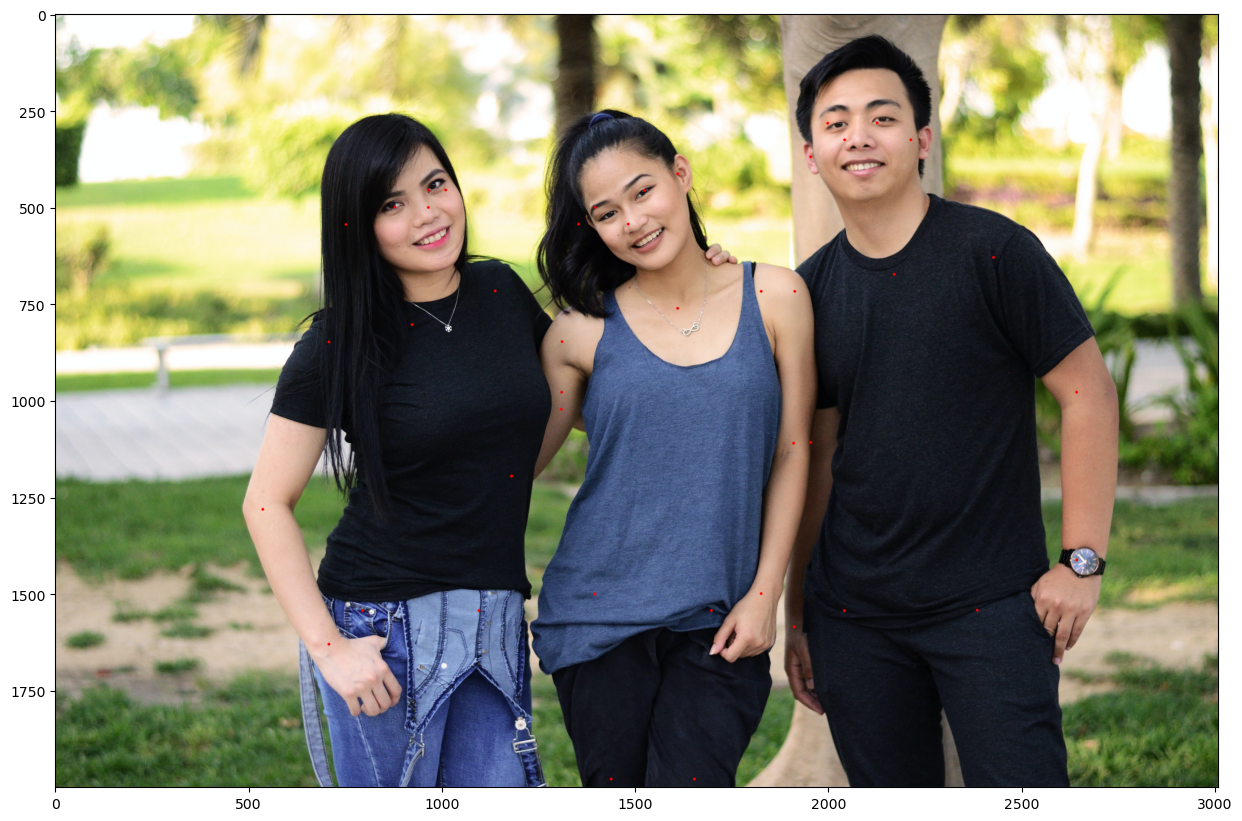

In [13]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [14]:
valid_pairs, invalid_pairs = getValidPairs(output)

No Connection : k = 8
No Connection : k = 11
[array([[3.        , 6.        , 0.7704315 ],
       [4.        , 7.        , 0.69893486],
       [5.        , 8.        , 0.79659497]]), array([[ 3.        , 16.        ,  0.83408272],
       [ 4.        , 15.        ,  0.6586017 ],
       [ 5.        , 17.        ,  0.84300447]]), array([[ 6.        ,  9.        ,  0.78927903],
       [ 7.        , 11.        ,  0.62609041],
       [ 8.        , 10.        ,  0.40665332]]), array([[ 9.        , 12.        ,  0.90612325],
       [10.        , 13.        ,  0.12916302],
       [11.        , 14.        ,  0.53915023]]), array([[15.        , 18.        ,  0.75524061],
       [16.        , 20.        ,  0.69272051],
       [17.        , 19.        ,  0.88754885]]), array([[18.        , 21.        ,  0.83868964],
       [19.        , 22.        ,  0.96137025],
       [20.        , 23.        ,  0.16785716]]), array([[ 3.        , 25.        ,  0.57150891],
       [ 4.        , 26.        ,  0.74

In [15]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

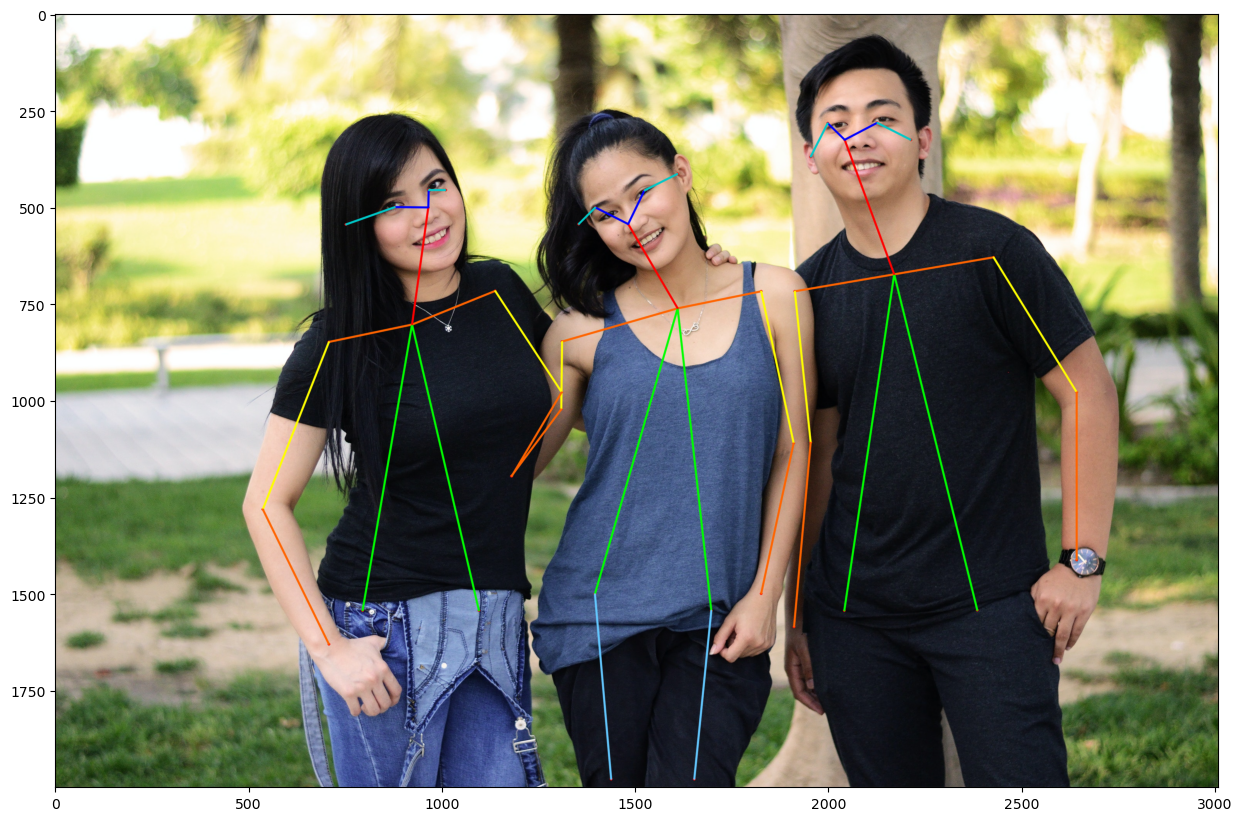

In [16]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

# Video

In [17]:
# usegpu == 'opencl'
net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

In [18]:
#cap = cv2.VideoCapture('Media/M4/dpose.mp4')
cap = cv2.VideoCapture('Media/M4/downloaded.mp4')
#fourcc = cv2.VideoWriter_fourcc(*'XVID')#(*'MP4V')
inWidth = int(cap.get(3))
inHeight = int(cap.get(4))
print(inHeight)
#out = cv2.VideoWriter(r'Media/M4/posed.mp4',fourcc, 20.0, (1280,720))
#out = cv2.VideoWriter(r'Media/M4/posed.mp4',fourcc, 20.0, (inWidth,inHeight))

while(True):
    ret, frame = cap.read()
    if not ret:
        break
    

    inWidth = frame.shape[1]
    inHeight = frame.shape[0]
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth,inHeight), (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()
    ##################################
    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.1

    for part in range(nPoints):
        probMap = output[0,part,:,:]
        #probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
        #plt.figure()
        #plt.imshow(255*np.uint8(probMap>threshold))
        keypoints = getKeypoints(probMap, threshold)
        #print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1

        detected_keypoints.append(keypoints_with_id)
    #
    personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)
    for i in range(17):
        for n in range(len(personwiseKeypoints)):
            index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
            if -1 in index:
                continue
            B = np.int32(keypoints_list[index.astype(int), 0])
            A = np.int32(keypoints_list[index.astype(int), 1])
            cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)

    #plt.figure(figsize=[15,15])
    #plt.imshow(frameClone[:,:,[2,1,0]])
    ##################################
    #print(frame)
    cv2.imshow('Pose Video',frame)
    #out.write(frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
#out.release()
cv2.destroyAllWindows()

144
